# **INITIAL SETUP**

## MODULES

In [236]:
import math
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import collections

In [127]:
import warnings
warnings.filterwarnings('ignore')

## GRAPH STYLE

In [128]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (25, 5)

In [129]:
sns.set_theme(style="darkgrid")
sns.set(style="ticks", context="talk")

## CONSTANTS

In [211]:
SET = {              # DATA SETS (date {"YYYY.MM.DD"}, NUM_COMPACTIONS, COMPLETION_COMPACTION)
    "Masado": [("2020.12.23", 7), ("2021.1.28", 5), ("2021.2.3", 6, 6), ("2021.2.5", 6, 5)],
    "Nenseido": [("2020.12.23", 7), ("2021.1.21", 6), ("2021.2.4", 5, 2), ("2021.2.6", 5, 2)],
    "Rekishitudo": [("2020.12.23", 7), ("2021.2.4", 6, 5), ("2021.2.5", 6, 6)]
}

#> NOTE: 2021.2.3_MASADO has non-conforming data labelling

# DATE_INDEXs FOR RELIABLE DATA
#> Masado - 3, 4
#> Nenseido - 3, 4
#> Rekishitudo - 2, 3

SOIL = {
    1: "Masado",     # マサド
    2: "Nenseido",   # 粘性土
    3: "Rekishitudo" # 礫土
}

COMPONENT = {        # DATA CHANNELS NAMING
    1: "ACC_X",      # CH1 - ACC_X
    2: "ACC_Y",      # CH2 - ACC_Y
    3: "ACC_Z",      # CH3 - ACC_Z
    4: "AUDIO"       # CH4 - AUDIO
}

COLOR = {            # GRAPHS COLORING
    0: "#39ff14",    # Idling       - Neon    
    1: "#ffa500",    # Compaction 1 - Orange
    2: "#eeee00",    # Compaction 2 - Yellow
    3: "#00cc00",    # Compaction 3 - Green
    4: "#ffffff",    # Compaction 4 - White
    5: "#cc00aa",    # Compaction 5 - Magenta
    6: "#aa0000",    # Compaction 6 - Red
    7: "#aaaa00"     # Compaction 6 - Moss Green
}

## Basic Functions

In [212]:
def set(soil_index, date_index):
    # Assume final compaction as completion compaction if completion compaction is not provided
    RET_3 = SET[SOIL[soil_index]][date_index-1][2] if len(SET[SOIL[soil_index]][date_index-1]) == 3 else SET[SOIL[soil_index]][date_index-1][1]

    return f"{SET[SOIL[soil_index]][date_index-1][0]}_{SOIL[soil_index]}", SET[SOIL[soil_index]][date_index-1][1], RET_3

In [213]:
def cout(message, log):
    if log: print(message)

In [209]:
# FMAX = 639.99

---

# **DATA MANIPULATION FUNCTIONS**

## FFT

Computer the Fast Fourier Transform

> - Returns the Power Spectral Density

In [177]:
def fft (t, v):
    """ Fast Fourier Transform """
    n = len(t)                                                                                          # Sample size
    dt = np.average(np.diff(t))                                                                         # Sampling gap
    fs = 1/dt                                                                                           # Sampling frequency (fs)
    f = np.arange(n//2) / n / dt                                                                        # Frequency domain frequencies, also => np.fft.fftfreq(n//2, dt)
    v_bar = np.fft.fft(v)                                                                               # Fast Fourier Transform
    v_bar = v_bar[:n//2]                                                                                # Nyquist Shannon Theorem => ∀f > fs/2 !v_bar[f]
    v_bar = np.sqrt(v_bar * np.conj(v_bar)) / n                                                         # Power Spectrum Density
    return f, abs(v_bar)

## WELCH METHOD

``` Estimates filtered (smoothened) Power Spectral Density ```


> - nperseg - increase by power of 2 to increase resolution

In [178]:
def welch(t, v, nperseg=2**13):
    """ Power Spectrum Density estimation using Welch's method """
    dt = np.average(np.diff(t))                                                                         # Sampling gap
    fs = 1/dt                                                                                           # Sampling frequency (fs)
    f, v_bar = signal.welch(v, fs=fs, window='hamming', nperseg=nperseg, noverlap=0)                    # Power Spectrum Density
    return f, abs(v_bar)

## FIND_K

``` Finds the frequency with the maximum amplitude in a given interval ```

In [179]:
def find_k (f, v_bar, k=1):
    """ Finds k frequencies with the maximum amplitude in a given interval """
    k_indices = np.argsort(v_bar)[-k:] # np.argpartition(v_bar, range(len(v_bar)-k, len(v_bar)))[-k:]    
    v_bar_dash = np.zeros(v_bar.size)
    v_bar_dash[k_indices] = v_bar[k_indices]
    if k == 1: return f, v_bar_dash, f[k_indices[-1]]
    else: return f, v_bar_dash, f[k_indices]

## BANDPASS FILTER *(HARD)*

> - Takes frequency domain data pair as input

In [322]:
def bpf(f, v_bar, lth=0, hth=-1):
    """ Bandpass Filter """
    if hth == -1: 
        return f[np.argmax(f>lth):], v_bar[np.argmax(f>lth):]
    else: 
        return f[np.argmax(f>lth):np.argmax(f>hth)], v_bar[np.argmax(f>lth):np.argmax(f>hth)]

## BANDPASS FILTER *(GRADUAL)*

>  - `Using Butterworth second order section`
>  - Takes time domain data pair as input 

In [323]:
def bbpf(t, v, lth=0, hth=-1, order=5):
    """ Butter Bandpass Filter """
    dt = np.average(np.diff(t))                                                                         # Sampling gap
    fs = 1/dt                                                                                           # Sampling frequency (fs)
    nyq = 0.5 * fs                                                                                      # Nyquist frequency = fs/2
    if hth == -1: hth = nyq
    sos = signal.butter(order, [lth / nyq, hth / nyq], analog=False, btype='band', output='sos')        # Cascaded second order sections
    x_filt = signal.sosfiltfilt(sos, v)                                                                 # Forward-backward digital filter
    return t, x_filt

---

# GRAPHING FUNCTIONS

``` The graphs are plotted on a logarithmic scale ```

> - `n` - compaction *(1 to 6)*
> - `c` - data value
>     - 1 - ACC_X
>     - 2 - ACC_Y
>     - 3 - ACC_Z
>     - 4 - AUDIO
> - `lth` - Lower frequency value for the bandpassfilter 
> - `hth` - Higher frequency value for the bandpassfilter
>         - set as -1 to set as maximum
>         - < 640

## graph()

Graph FFT and Welch transforms in the same graph

In [339]:
def graph(soil_index, date_index, compaction_index, component_index=1, lth=25, hth=-1):
    """ Graph FFT and Welch in the same plot """
    PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)
    t, *v = np.genfromtxt(f'data/{PATH}/CLEANED/{compaction_index}.csv', delimiter=',', unpack=True)
    plt.semilogy(*bpf(*fft(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"FFT_{compaction_index} | {COMPONENT[component_index]}")
#     plt.plot(*bpf(*fft(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"FFT_{compaction_index} | {COMPONENT[component_index]}")
    plt.semilogy(*bpf(*welch(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"WELCH_{compaction_index} | {COMPONENT[component_index]}")
#     plt.plot(*bpf(*welch(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"WELCH_{compaction_index} | {COMPONENT[component_index]}")
    plt.title(f"{PATH} - Compaction {compaction_index} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
#     plt.legend(loc='best')
    plt.tight_layout()

## wave()

Graph *Wave* data for a given compaction

In [340]:
# def wave(soil_index, date_index, compaction_index, component_index=1, lth=25, hth=-1):
#     """ Graph the Wave data """
#     PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)
#     plt.semilogy(*bpf(*np.genfromtxt(f'data/{PATH}/CLEANED/Wave_{compaction_index}{component_index}.csv', delimiter=',', unpack = True), lth, hth), color = COLOR[compaction_index]) #, label = f"WAVE_{compaction_index} | {COMPONENT[component_index]}")
#     plt.title(f"{PATH} - Compaction {compaction_index} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
# #     plt.legend(loc='best')
#     plt.tight_layout()

## compare_graph()

Compare FFT, Welch, and Wave frequency domain data in different graphs

In [341]:
# def compare_graph(soil_index, date_index, compaction_index, component_index=1, lth=25, hth=-1):
#     """ Compare FFT, Welch, and Wave frequency domain data in different graphs """
#     PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)
#     fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = True)
#     t, *v = np.genfromtxt(f'data/{PATH}/CLEANED/{compaction_index}.csv', delimiter=',', unpack=True)
#     ax1.semilogy(*bpf(*fft(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"FFT_{compaction_index} | {COMPONENT[component_index]}")
#     ax2.semilogy(*bpf(*welch(t, v[component_index-1]), lth, hth), color = COLOR[compaction_index]) #, label = f"WELCH_{compaction_index} | {COMPONENT[component_index]}")
#     ax3.semilogy(*bpf(*np.genfromtxt(f'data/{PATH}/CLEANED/Wave_{compaction_index}{component_index}.csv', delimiter=',', unpack = True), lth, hth), color = COLOR[compaction_index]) #, label = f"WAVE_{compaction_index} | {COMPONENT[component_index]}")
#     plt.title(f"{PATH} - Compaction {compaction_index} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
# #     plt.legend(loc='best')
#     plt.tight_layout()

## listk()

> Plot the highest frequency in the given frequency interval for every compaction
>> - `visual` - Set *False* to omit the graph 
>> - `ft` - Transform method to use
>>     - Set as `fft` to use *FFT*                - more noise, but highest resolution
>>     - Set as `welch` to use *Welch Estimation* - lower noise (set high *nperseg* to improve resolution if required)

``` The function prints the frequencies (and their corresponding compactions) sorted in ascending order ```

In [390]:
def listk(soil_index, date_index, component_index = 1, lth=25, hth=-1, visual=True, log = True, limit_on_completion = -1, ft = fft):
    PATH, NUM_COMPACTIONS, COMP_COMPACTIONS= set(soil_index, date_index)

    if limit_on_completion < 0: LIMIT_COMPACTIONS = NUM_COMPACTIONS
    elif limit_on_completion == 0: LIMIT_COMPACTIONS = COMP_COMPACTIONS
    elif limit_on_completion < NUM_COMPACTIONS: LIMIT_COMPACTIONS = limit_on_completion
    else: LIMIT_COMPACTIONS = NUM_COMPACTIONS

    data = np.array([None] * LIMIT_COMPACTIONS)
    fk = np.array([None] * LIMIT_COMPACTIONS)
    
    cout(f"******************************************************** {COMPONENT[component_index]} ********************************************************", log)
    for compaction_index in range(0, LIMIT_COMPACTIONS):
        data[compaction_index] = np.genfromtxt(f'data/{PATH}/CLEANED/{compaction_index+1}.csv', delimiter=',', unpack=True)
        *vb, fk[compaction_index] = find_k(*bpf(*ft(data[compaction_index][0], data[compaction_index][component_index-1]), lth, hth))
        if visual: 
#             plt.plot(*vb, label = f"{compaction_index+1}", color = COLOR[compaction_index+1])
            plt.semilogy(*vb, label = f"{compaction_index+1}", color = COLOR[compaction_index+1])
#             cout(f"->> [{compaction_index+1}] {fk[compaction_index]}", log) # {', '.join(str(f) for f in fk[compaction_index])}

    if visual: 
        plt.title(f"{PATH} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")
        plt.legend(loc='best')
        plt.tight_layout()
#         cout(f"-------------------------", log)
    
    cout(f"< > Sorted Frequencies (left to right compactions) - [{', '.join(map(lambda x:(' %5s   '%str(x + 1)), np.argsort(fk)))}]", log)
    cout(f"< > Sorted Frequencies (low to high frequencies)   - [{', '.join(map(lambda x:('%9s'%('%.5f'%x)), fk[np.argsort(fk)]))}]", log)
    
    return np.argsort(fk)

## `compose()`

> Use this function to experiment 

In [391]:
def compose(soil_index, date_index, component_index=1, lth=25, hth=-1, visual=True, log = True, limit_on_completion = -1, ft=welch):
    PATH, NUM_COMPACTIONS, COMP_COMPACTIONS = set(soil_index, date_index)

    if limit_on_completion < 0: LIMIT_COMPACTIONS = NUM_COMPACTIONS
    elif limit_on_completion == 0: LIMIT_COMPACTIONS = COMP_COMPACTIONS
    elif limit_on_completion < NUM_COMPACTIONS: LIMIT_COMPACTIONS = limit_on_completion
    else: LIMIT_COMPACTIONS = NUM_COMPACTIONS

    if visual: 
        for compaction_index in range(0, LIMIT_COMPACTIONS):
            graph(soil_index, date_index, compaction_index+1, component_index, lth, hth)
        plt.title(f"{PATH} | {COMPONENT[component_index]} | {lth} Hz - {hth if hth > 0 else 'MAX'} Hz")

    pattern = listk(soil_index, date_index, component_index, lth, hth, visual, log, limit_on_completion, ft)
    return ''.join(map(lambda x:str(x + 1), pattern))

---

# **GRAPHS**

Ranges of interest are handpicked based on observations from the graphs. They are written under their component headings.  
Please follow these examples to see how to read them.

> `X6 = [52, 257, 397]` implies that the ranges of interest for `ACC_X` are 
>> - `[52 - 6 , 52 + 6]`   = `[46, 58] Hz`
>> - `[257 - 6 , 257 + 6]` = `[251, 263] Hz`
>> - `[397 - 6 , 397 + 6]` = `[391, 403] Hz`

> `Y3 = [397, 404]` implies that the ranges of interest for `ACC_Y` are 
>> - `[397 - 3 , 397 + 3]` = `[394, 400] Hz`
>> - `[404 - 3 , 404 + 3]` = `[401, 407] Hz`

The following are the frequency domain graphs around the points of interest for each for the data components.

---

In [392]:
OVERTONES = [52, 103, 155, 206, 257, 310, 360]

---

```QUERY FOR PATTERN ANALYSIS```

In [ ]:
patterns = []
for overtone in OVERTONES:
    for (soil_index, date_index) in [(1, 3)]:#, (1, 4)]:#, (3, 2), (3, 3), (2, 3), (2, 4)]: # All the data taken in February
        for component in range(2, 3): 
            patterns.append(compose(soil_index, date_index, component, overtone - 6, overtone + 6, True, False))

******************************************************** ACC_X ********************************************************
< > Sorted Frequencies (left to right compactions) - [     2   ,      5   ,      4   ,      1   ,      3   ]
< > Sorted Frequencies (low to high frequencies)   - [ 25.15625,  25.15625,  25.15625,  25.15625,  25.15625]


'25413'

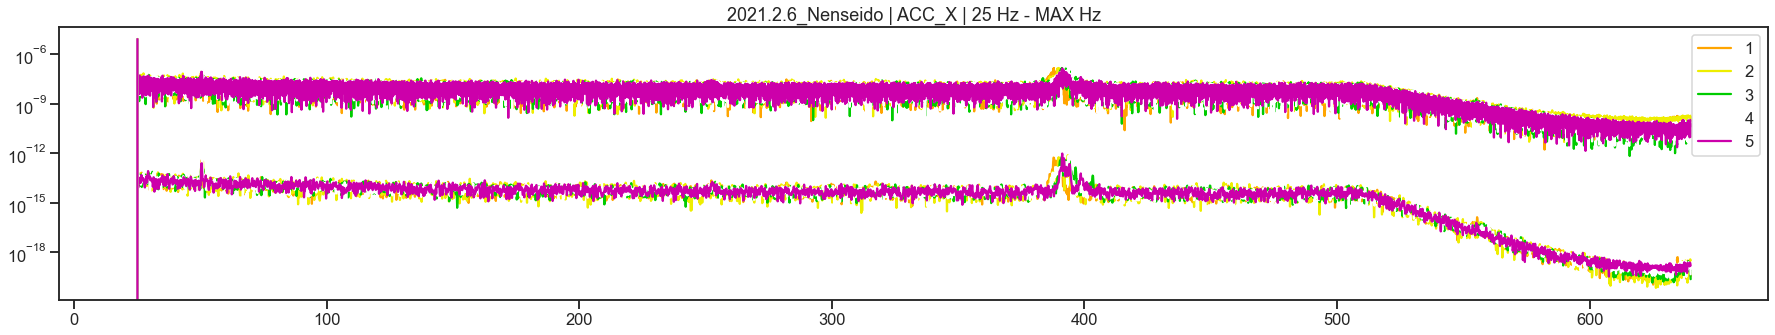

In [459]:
compose(2, 4, 1)

******************************************************** ACC_Y ********************************************************
< > Sorted Frequencies (left to right compactions) - [     1   ,      3   ,      5   ,      2   ,      4   ]
< > Sorted Frequencies (low to high frequencies)   - [387.81250, 391.09375, 391.25000, 393.43750, 393.75000]


'13524'

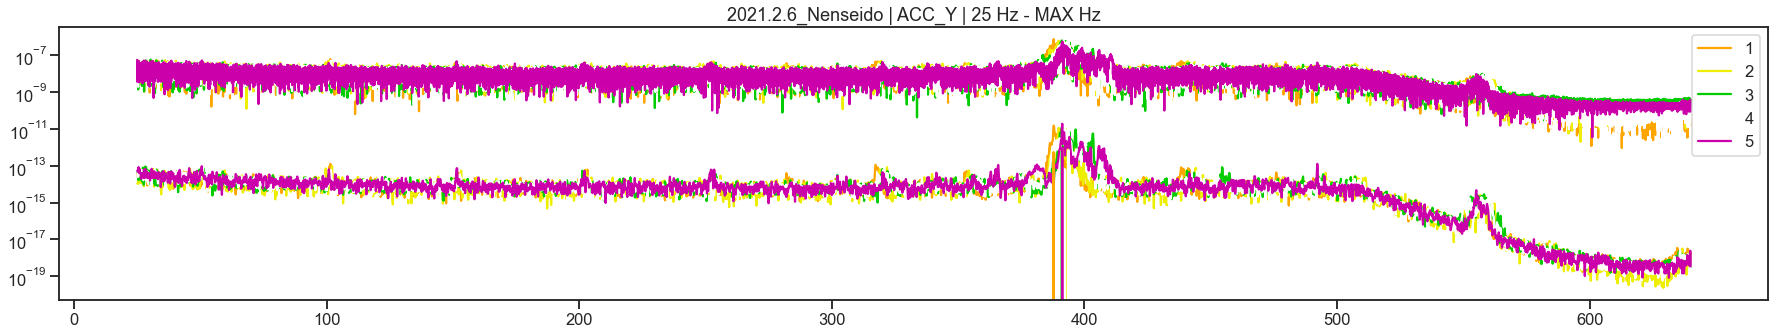

In [460]:
compose(2, 4, 2)

******************************************************** ACC_Z ********************************************************
< > Sorted Frequencies (left to right compactions) - [     1   ,      3   ,      5   ,      2   ,      4   ]
< > Sorted Frequencies (low to high frequencies)   - [387.96875, 391.09375, 391.25000, 393.43750, 393.59375]


'13524'

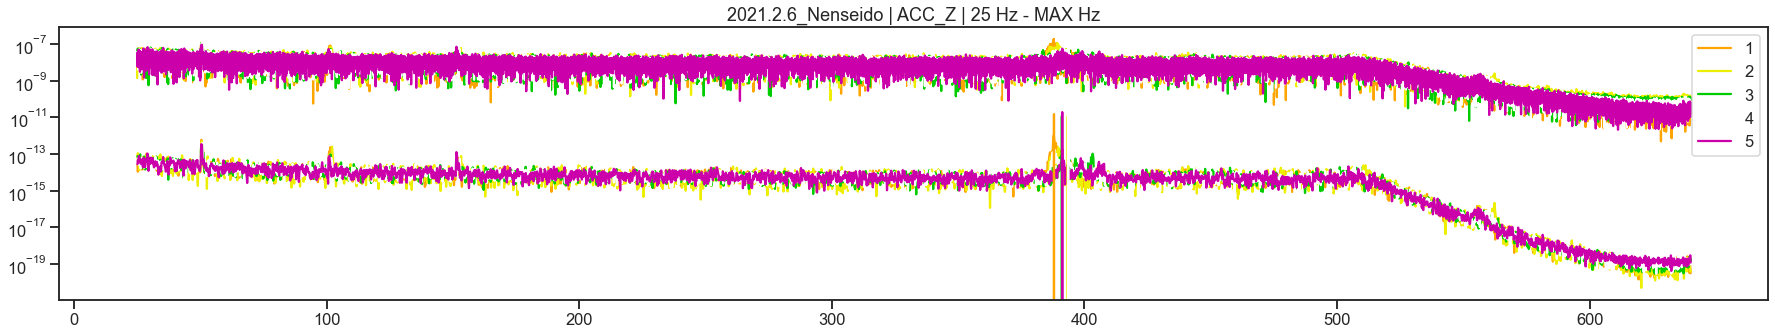

In [461]:
compose(2, 4, 3)

******************************************************** AUDIO ********************************************************
< > Sorted Frequencies (left to right compactions) - [     5   ,      2   ,      4   ,      3   ,      1   ]
< > Sorted Frequencies (low to high frequencies)   - [ 50.46875,  50.62500,  50.78125,  50.78125, 387.81250]


'52431'

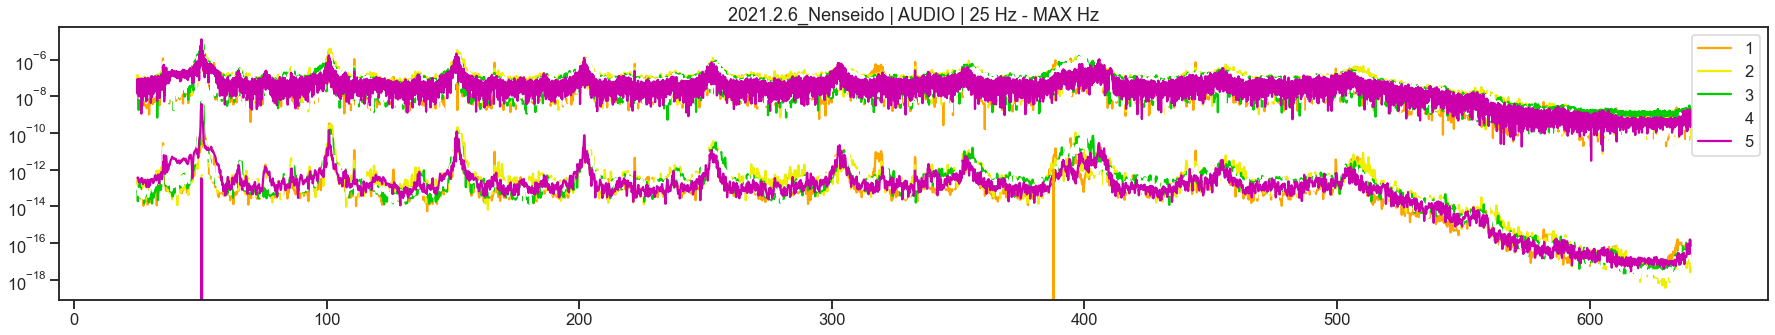

In [462]:
compose(2, 4, 4)

---

## PATTERN ANALYSIS

### The graph below is of all the patterns determined from the query ran above

In [424]:
patterns_int = np.array(list(map(lambda pat:int(pat), patterns)))
patterns_str = list(map(lambda pat:str(pat), patterns_int[np.argsort(patterns_int)]))

<AxesSubplot:ylabel='count'>

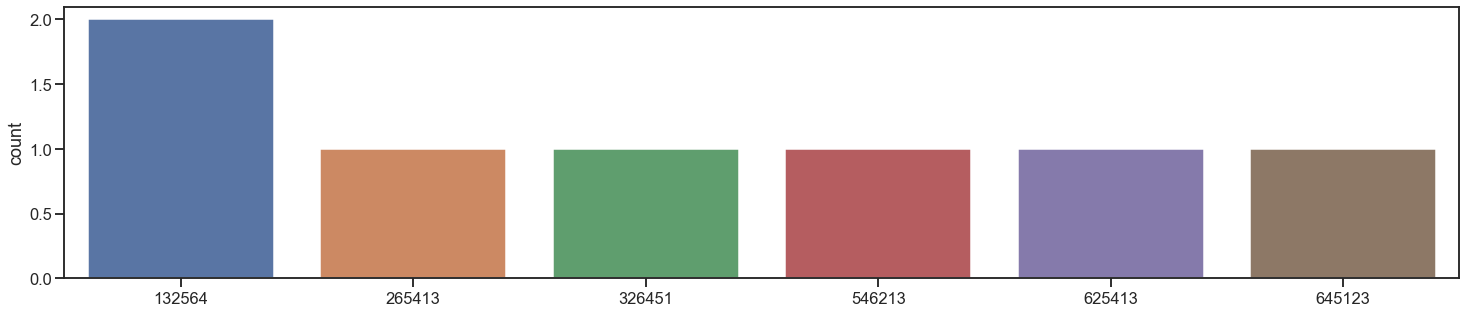

In [425]:
sns.countplot(x = patterns_str)

### The graph below is of the patterns, observed from the above query, whose frequencies are greater than *PATTERN_THRESHOLD*

In [426]:
PATTERN_THRESHOLD = 0

In [427]:
occurrences = collections.Counter(patterns)
OD = collections.OrderedDict(sorted({key:val for key, val in occurrences.items() if val > PATTERN_THRESHOLD}.items()))

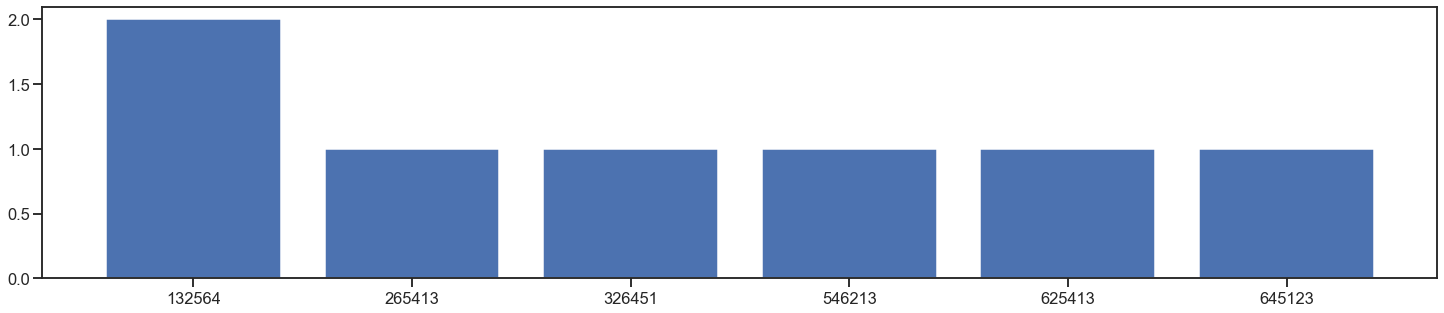

In [428]:
plt.bar(*zip(*OD.items()))
plt.show()